<a href="https://colab.research.google.com/github/G0rav/Image_Segmentation/blob/main/UNet_using_pix2pix_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#pet

https://www.tensorflow.org/tutorials/images/segmentation

https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

https://keras.io/examples/vision/oxford_pets_image_segmentation/

https://nbviewer.jupyter.org/github/G0rav/Image_Segmentation/blob/main/Unet.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
% matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'

In [ ]:
pet, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteW9ZZ5U/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteW9ZZ5U/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
train = pet['train'].map(load_image)
test = pet['test'].map(load_image)

In [ ]:
len(train), len(test)

(3680, 3669)

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def show_images(display_list,title_list):
  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title_list[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
  plt.show()

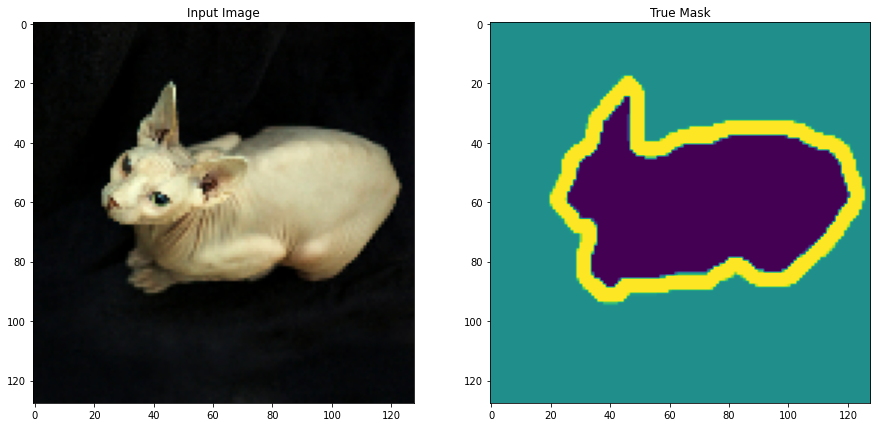

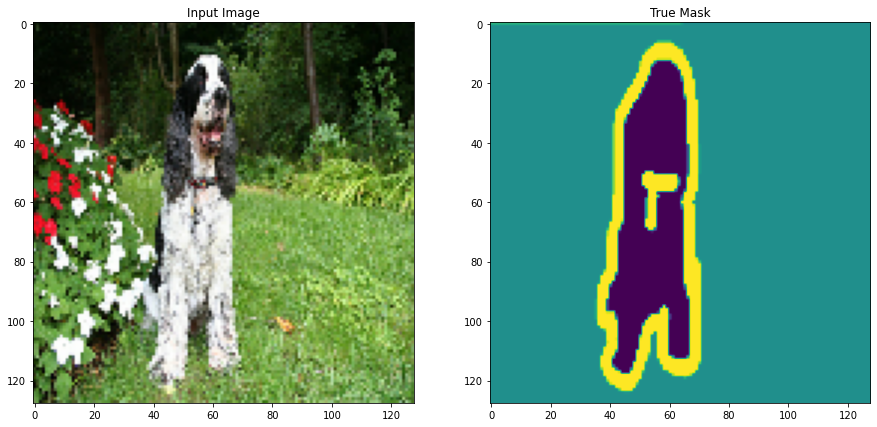

In [ ]:
for image, mask in train.take(2):
  sample_image, sample_mask = image, mask
  show_images([sample_image, sample_mask],
        ['Input Image', 'True Mask'])



In [ ]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

NameError: ignored

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Image segmentation/oxford_segmentation_pix2pix_structure.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model_history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/15
58/58 [==============================] - 35s 405ms/step - loss: 2.2057 - val_loss: 3.4376
Epoch 2/15
58/58 [==============================] - 22s 380ms/step - loss: 0.6196 - val_loss: 3.2437
Epoch 3/15
58/58 [==============================] - 22s 382ms/step - loss: 0.5656 - val_loss: 4.2592
Epoch 4/15
58/58 [==============================] - 22s 384ms/step - loss: 0.5233 - val_loss: 4.9146
Epoch 5/15
58/58 [==============================] - 22s 387ms/step - loss: 0.4959 - val_loss: 5.2124
Epoch 6/15
58/58 [==============================] - 22s 386ms/step - loss: 0.4662 - val_loss: 4.3109
Epoch 7/15
58/58 [==============================] - 22s 386ms/step - loss: 0.4339 - val_loss: 3.7856
Epoch 8/15
58/58 [==============================] - 22s 389ms/step - loss: 0.4153 - val_loss: 5.1101
Epoch 9/15
58/58 [==============================] - 23s 391ms/step - loss: 0.3849 - val_loss: 3.8088
Epoch 10/15
58/58 [==============================] - 22s 386ms/step - loss: 0.3648 - val_lo

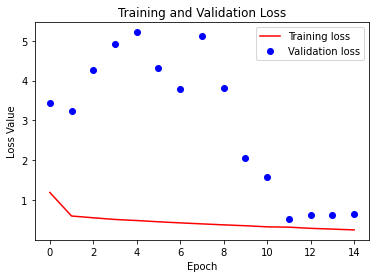

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in train_dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

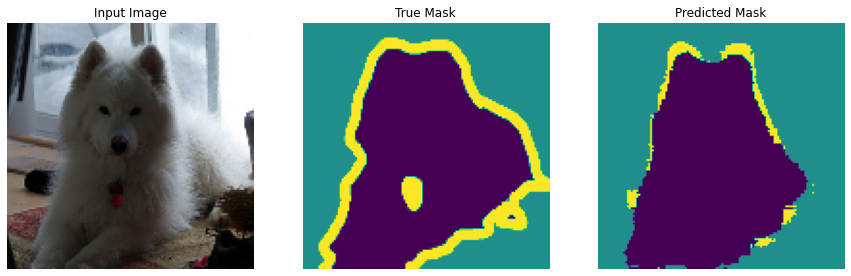

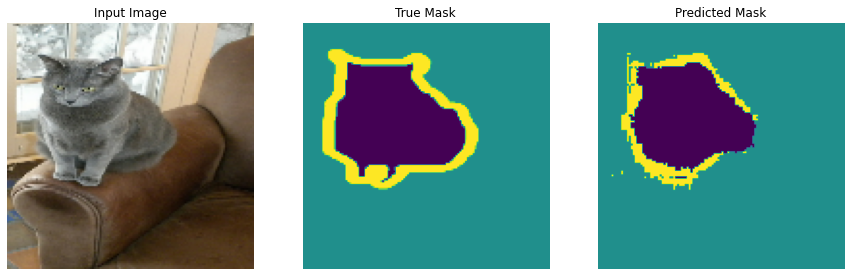

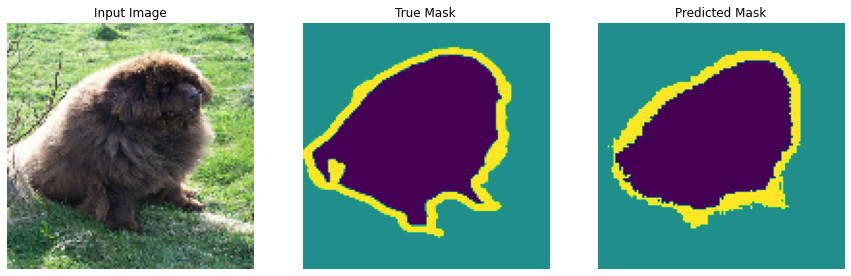

In [ ]:
show_predictions(test_dataset, 3)

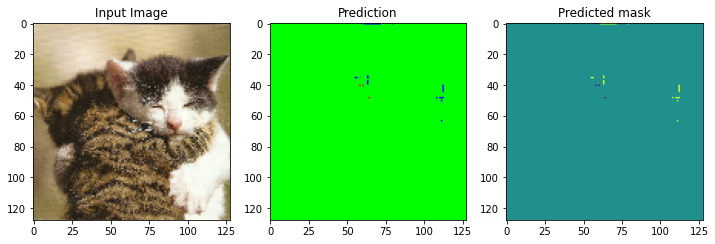

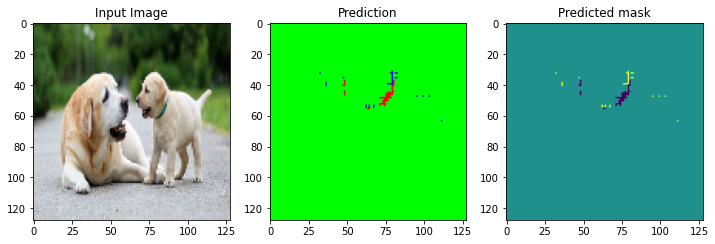

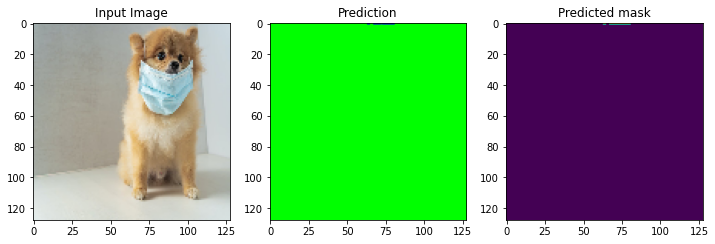

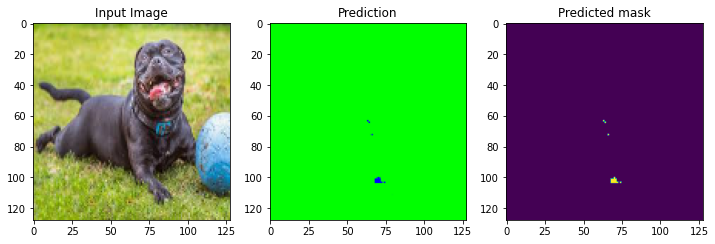

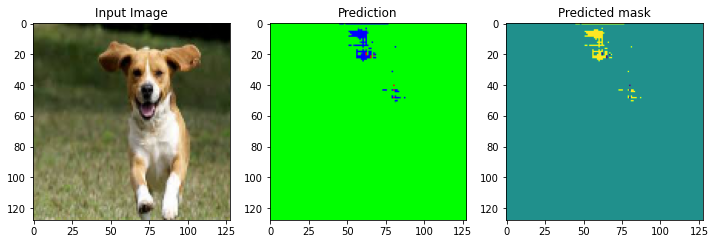

In [ ]:
path ='/content/drive/MyDrive/Colab Notebooks/Image segmentation/'
for i in range(1,6):
  plt.figure(figsize= (12,12))
  
  plt.subplot(1,3,1)
  img = plt.imread(path + str(i)+'.jpg')
  img = cv2.resize(img, (128,128))
  plt.imshow(img)
  plt.title('Input Image')

  plt.subplot(1,3,2)
  img = img.reshape((1,) + img.shape)
  pred = model.predict(img)
  pred = pred.reshape(pred.shape[1:])
  plt.imshow(pred)
  plt.title('Prediction')

  plt.subplot(1,3,3)
  pred_mask = tf.argmax(pred, axis=-1)
  plt.imshow(pred_mask)
  plt.title('Predicted mask')
  plt.show()